In [14]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
import pandas as pd
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from torch_geometric.nn import SAGEConv, global_mean_pool
from utils import get_feature_propagation
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from Models.GAT import GATClassification
from Models.GraphSage import GraphSAGEClassfication
from Models.Transformer import TransformerClassification
from Models.GATv2 import GATv2Classification
import matplotlib.pyplot as plt

In [15]:
data = torch.load('Data/santiago_zero_ismt.pt')
data.y = data.x[:,-1] # Select GSE
data.x = data.x[:, 2:8]
print(data)
print(data.x)
print(data.y)
print(data.edge_index)
print(data.edge_attributes)

Data(x=[337374, 6], edge_index=[2, 641693], edge_attributes=[641693, 2], y=[337374])
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.5074, -1.1100, -1.6402,  1.2143,  1.6439,  1.6780],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])
tensor([1., 1., 1.,  ..., 1., 1., 1.])
tensor([[     0,      1,      2,  ..., 337372, 337373, 337373],
        [  4237,   4241,    480,  ..., 184408, 239479,   7705]])
tensor([[80.8500,  5.8000],
        [18.8300,  1.3000],
        [16.0600,  1.1000],
        ...,
        [33.0400,  4.1000],
        [ 2.5300,  0.2000],
        [ 6.4800,  0.6000]])


In [16]:
data.x = get_feature_propagation(data)

Starting feature filling
tensor([[-1.8762,  0.0880,  1.8812, -0.7552, -2.0797, -1.2788],
        [ 0.2155, -0.1407, -0.2000,  0.7840,  0.9977,  0.7484],
        [ 0.0507, -1.1760, -0.3934,  1.3322,  0.4679,  0.7087],
        ...,
        [ 1.0445, -1.0450, -1.3092,  1.1516,  1.1633,  1.0873],
        [ 1.5074, -1.1100, -1.6402,  1.2143,  1.6439,  1.6780],
        [ 1.2992, -0.1245, -1.1497,  0.2336,  1.0391,  0.9675]])
Feature filling completed. It took: 2.02s


In [4]:
count_gse = {}
for i in data.y.tolist():
    if i not in count_gse:
        count_gse[i] = 0
    count_gse[i] += 1
count_gse

{1.0: 81492, 2.0: 75116, 3.0: 130226, 0.0: 49543, 4.0: 997}

In [17]:
index_list = data.edge_index.flatten().unique().tolist()

# Porcentaje de índices para cada conjunto
train_percentage = 0.5
val_percentage = 0.25

# Dividir en conjuntos de entrenamiento y prueba
train_index, remaining_index = train_test_split(index_list, train_size=train_percentage, random_state=42)

# Dividir el resto en conjuntos de validación y prueba
val_index, test_index = train_test_split(remaining_index, train_size=val_percentage / (1 - train_percentage), random_state=42)

print("Training set length:", len(train_index))
print("Validation set length:", len(val_index))
print("Test set length:", len(test_index))

n_nodes, n_features = data.x.shape

train_mask = torch.zeros(n_nodes, dtype=torch.bool)
val_mask = torch.zeros(n_nodes, dtype=torch.bool)
test_mask = torch.zeros(n_nodes, dtype=torch.bool)

train_mask[train_index] = True
val_mask[val_index] = True
test_mask[test_index] = True
data['train_mask'] = train_mask
data['val_mask'] = val_mask
data['test_mask'] = test_mask

Training set length: 168647
Validation set length: 84323
Test set length: 84324


## GraphSage Classification

In [18]:
in_features = data.x.shape[1]
hidden_features = 16
out_features = 5
num_layers = 2
epochs = 300
lr = 0.01

model = GraphSAGEClassfication(in_features, hidden_features, out_features, num_layers, dropout=0.6)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def train_model(model, data, mask):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)[mask]
    pred = torch.argmax(out, dim=1)
    loss = F.cross_entropy(out, data.y[mask].long())
    acc_train = accuracy_score(data.y[mask].long(), pred)
    accs_train.append(acc_train)
    loss.backward()
    optimizer.step()
    return loss.item(), acc_train

def evaluate_model(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)[mask]
        pred = torch.argmax(out, dim=1)
        loss = F.cross_entropy(out, data.y[mask].long())
        acc = accuracy_score(data.y[mask].long(), pred)
        recall = recall_score(data.y[mask].long(), pred, average='weighted')
        f1 = f1_score(data.y[mask].long(), pred, average='weighted')
    return loss.item(), acc, recall, f1

train_losses = []
val_losses = []
accs_train = []
accs_val = []
recalls = []
f1_scores = []

for epoch in range(epochs):
    train_loss, acc_train = train_model(model, data, data.train_mask)
    val_loss, val_acc, val_recall, val_f1 = evaluate_model(model, data, data.val_mask)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accs_val.append(val_acc)
    recalls.append(val_recall)
    f1_scores.append(val_f1)
    
    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Train Acc: {acc_train:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}')

_, test_acc, test_recall, test_f1 = evaluate_model(model, data, data.test_mask)
print(f'Test Acc: {test_acc:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}')

Epoch: 001, Train Loss: 1.6465, Train Acc: 0.0860, Val Loss: 1.6079, Val Acc: 0.2552, Val Recall: 0.2552, Val F1: 0.2036
Epoch: 002, Train Loss: 1.6103, Train Acc: 0.1890, Val Loss: 1.5807, Val Acc: 0.3844, Val Recall: 0.3844, Val F1: 0.2140
Epoch: 003, Train Loss: 1.5848, Train Acc: 0.2654, Val Loss: 1.5547, Val Acc: 0.3844, Val Recall: 0.3844, Val F1: 0.2135
Epoch: 004, Train Loss: 1.5610, Train Acc: 0.3265, Val Loss: 1.5286, Val Acc: 0.3844, Val Recall: 0.3844, Val F1: 0.2135
Epoch: 005, Train Loss: 1.5395, Train Acc: 0.3402, Val Loss: 1.5014, Val Acc: 0.3844, Val Recall: 0.3844, Val F1: 0.2135
Epoch: 006, Train Loss: 1.5196, Train Acc: 0.3818, Val Loss: 1.4742, Val Acc: 0.3845, Val Recall: 0.3845, Val F1: 0.2137
Epoch: 007, Train Loss: 1.5018, Train Acc: 0.3759, Val Loss: 1.4483, Val Acc: 0.3847, Val Recall: 0.3847, Val F1: 0.2142
Epoch: 008, Train Loss: 1.4879, Train Acc: 0.3666, Val Loss: 1.4244, Val Acc: 0.3850, Val Recall: 0.3850, Val F1: 0.2149
Epoch: 009, Train Loss: 1.4753, 

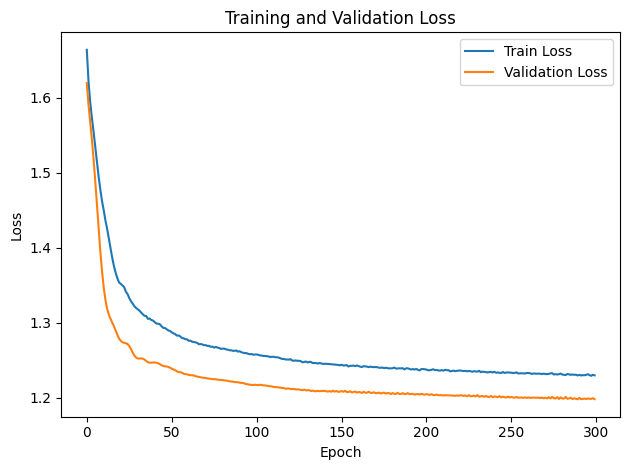

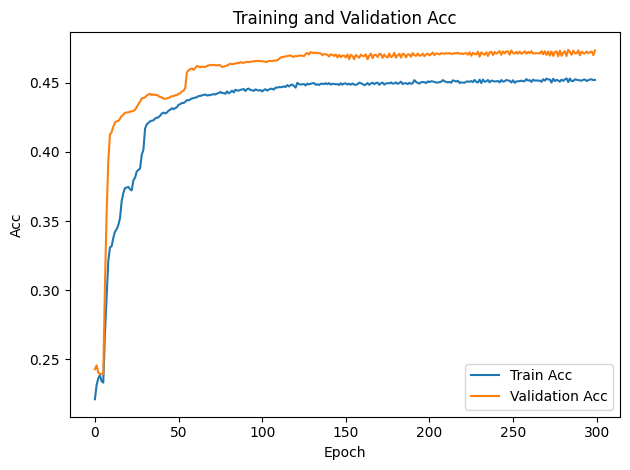

In [46]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

plt.plot(accs_train, label='Train Acc')
plt.plot(accs_val, label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()
plt.title('Training and Validation Acc')

plt.tight_layout()
plt.show()

## GAT Classification

In [7]:
in_features = data.x.shape[1]
hidden_features = 16
out_features = 5
num_layers = 2
epochs = 300
lr = 0.01
num_heads = 6

model = GATClassification(in_features, hidden_features, out_features, edge_dim=2, heads=num_heads, num_layers=2, dropout=0.6)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

def train_model(model, data, mask):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attributes)[mask]
    pred = torch.argmax(out, dim=1)
    loss = F.cross_entropy(out, data.y[mask].long())
    acc_train = accuracy_score(data.y[mask].long(), pred)
    accs_train.append(acc_train)
    loss.backward()
    optimizer.step()
    return loss.item(), acc_train

def evaluate_model(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.edge_attributes)[mask]
        pred = torch.argmax(out, dim=1)
        loss = F.cross_entropy(out, data.y[mask].long())
        acc = accuracy_score(data.y[mask].long(), pred)
        recall = recall_score(data.y[mask].long(), pred, average='weighted')
        f1 = f1_score(data.y[mask].long(), pred, average='weighted')
    return loss.item(), acc, recall, f1

train_losses = []
val_losses = []
accs_train = []
accs_val = []
recalls = []
f1_scores = []

for epoch in range(epochs):
    train_loss, acc_train = train_model(model, data, data.train_mask)
    val_loss, val_acc, val_recall, val_f1 = evaluate_model(model, data, data.val_mask)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accs_val.append(val_acc)
    recalls.append(val_recall)
    f1_scores.append(val_f1)
    
    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Train Acc: {acc_train:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}')

_, test_acc, test_recall, test_f1 = evaluate_model(model, data, data.test_mask)
print(f'Test Acc: {test_acc:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}')

Epoch: 001, Train Loss: 1.8230, Train Acc: 0.1727, Val Loss: 1.4905, Val Acc: 0.4045, Val Recall: 0.4045, Val F1: 0.3357
Epoch: 002, Train Loss: 1.6283, Train Acc: 0.3630, Val Loss: 1.4282, Val Acc: 0.4031, Val Recall: 0.4031, Val F1: 0.3329
Epoch: 003, Train Loss: 1.5767, Train Acc: 0.3462, Val Loss: 1.3836, Val Acc: 0.4027, Val Recall: 0.4027, Val F1: 0.3462
Epoch: 004, Train Loss: 1.5216, Train Acc: 0.3433, Val Loss: 1.3450, Val Acc: 0.4300, Val Recall: 0.4300, Val F1: 0.3502
Epoch: 005, Train Loss: 1.4758, Train Acc: 0.3493, Val Loss: 1.3321, Val Acc: 0.4389, Val Recall: 0.4389, Val F1: 0.3643
Epoch: 006, Train Loss: 1.4519, Train Acc: 0.3541, Val Loss: 1.3280, Val Acc: 0.4284, Val Recall: 0.4284, Val F1: 0.3503
Epoch: 007, Train Loss: 1.4414, Train Acc: 0.3557, Val Loss: 1.3176, Val Acc: 0.4254, Val Recall: 0.4254, Val F1: 0.3236
Epoch: 008, Train Loss: 1.4264, Train Acc: 0.3615, Val Loss: 1.3045, Val Acc: 0.4236, Val Recall: 0.4236, Val F1: 0.3158
Epoch: 009, Train Loss: 1.4134, 

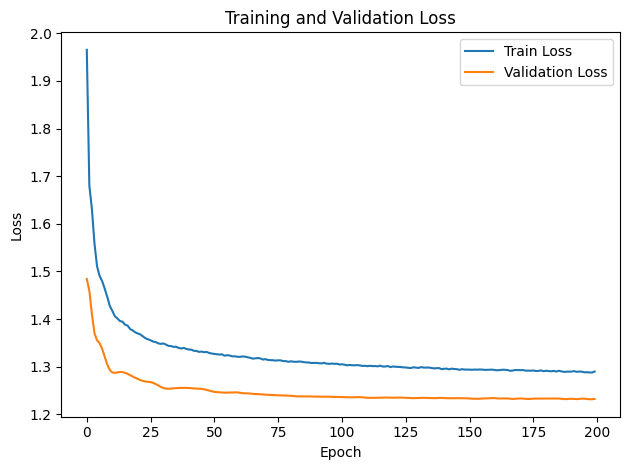

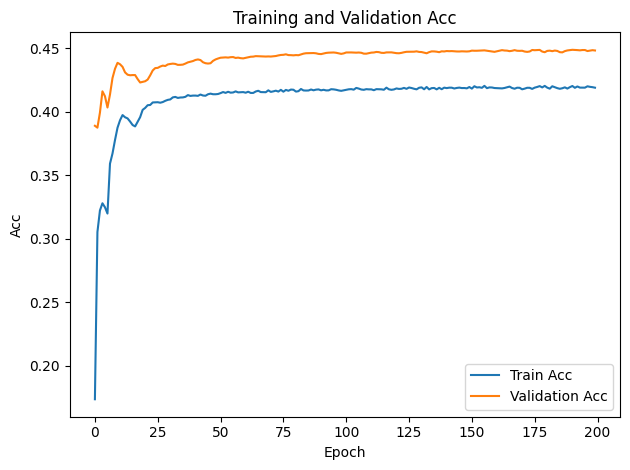

In [7]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

plt.plot(accs_train, label='Train Acc')
plt.plot(accs_val, label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()
plt.title('Training and Validation Acc')

plt.tight_layout()
plt.show()

## TransfomerConv

In [6]:
in_features = data.x.shape[1]
hidden_features = 8
out_features = 5
num_layers = 2
epochs = 200
lr = 0.01
num_heads = 4

model = TransformerClassification(in_features, hidden_features, out_features, edge_dim=2, heads=num_heads, num_layers=2, dropout=0.6)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

def train_model(model, data, mask):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attributes)[mask]
    pred = torch.argmax(out, dim=1)
    loss = F.cross_entropy(out, data.y[mask].long())
    acc_train = accuracy_score(data.y[mask].long(), pred)
    accs_train.append(acc_train)
    loss.backward()
    optimizer.step()
    return loss.item(), acc_train

def evaluate_model(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.edge_attributes)[mask]
        pred = torch.argmax(out, dim=1)
        loss = F.cross_entropy(out, data.y[mask].long())
        acc = accuracy_score(data.y[mask].long(), pred)
        recall = recall_score(data.y[mask].long(), pred, average='weighted')
        f1 = f1_score(data.y[mask].long(), pred, average='weighted')
    return loss.item(), acc, recall, f1

train_losses = []
val_losses = []
accs_train = []
accs_val = []
recalls = []
f1_scores = []

for epoch in range(epochs):
    train_loss, acc_train = train_model(model, data, data.train_mask)
    val_loss, val_acc, val_recall, val_f1 = evaluate_model(model, data, data.val_mask)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accs_val.append(val_acc)
    recalls.append(val_recall)
    f1_scores.append(val_f1)
    
    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Train Acc: {acc_train:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}')

_, test_acc, test_recall, test_f1 = evaluate_model(model, data, data.test_mask)
print(f'Test Acc: {test_acc:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}')

Epoch: 001, Train Loss: 16.8179, Train Acc: 0.1836, Val Loss: 3.8170, Val Acc: 0.3785, Val Recall: 0.3785, Val F1: 0.2376
Epoch: 002, Train Loss: 7.6203, Train Acc: 0.3166, Val Loss: 2.2475, Val Acc: 0.3891, Val Recall: 0.3891, Val F1: 0.2255
Epoch: 003, Train Loss: 5.2094, Train Acc: 0.2921, Val Loss: 1.6436, Val Acc: 0.3530, Val Recall: 0.3530, Val F1: 0.2784
Epoch: 004, Train Loss: 3.8692, Train Acc: 0.2655, Val Loss: 1.5465, Val Acc: 0.2770, Val Recall: 0.2770, Val F1: 0.2391
Epoch: 005, Train Loss: 3.0499, Train Acc: 0.2398, Val Loss: 1.6392, Val Acc: 0.2092, Val Recall: 0.2092, Val F1: 0.1620
Epoch: 006, Train Loss: 2.6026, Train Acc: 0.2093, Val Loss: 1.7421, Val Acc: 0.1546, Val Recall: 0.1546, Val F1: 0.1061
Epoch: 007, Train Loss: 2.4055, Train Acc: 0.1820, Val Loss: 1.6658, Val Acc: 0.1200, Val Recall: 0.1200, Val F1: 0.1264
Epoch: 008, Train Loss: 2.2477, Train Acc: 0.1766, Val Loss: 1.4719, Val Acc: 0.3413, Val Recall: 0.3413, Val F1: 0.2682
Epoch: 009, Train Loss: 2.0464,

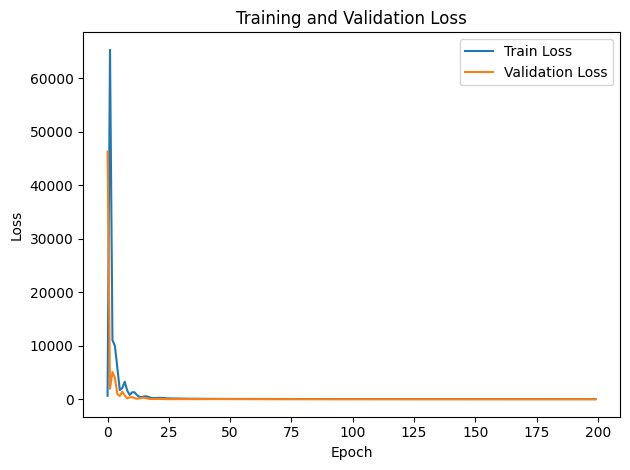

In [10]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

## GATv2

In [9]:
in_features = data.x.shape[1]
hidden_features = 16
out_features = 5
num_layers = 1
epochs = 300
lr = 0.01
num_heads = 8

model = GATv2Classification(in_features, hidden_features, out_features, edge_dim=2, heads=num_heads, num_layers=2, dropout=0.6)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

def train_model(model, data, mask):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attributes)[mask]
    pred = torch.argmax(out, dim=1)
    loss = F.cross_entropy(out, data.y[mask].long())
    acc_train = accuracy_score(data.y[mask].long(), pred)
    accs_train.append(acc_train)
    loss.backward()
    optimizer.step()
    return loss.item(), acc_train

def evaluate_model(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.edge_attributes)[mask]
        pred = torch.argmax(out, dim=1)
        loss = F.cross_entropy(out, data.y[mask].long())
        acc = accuracy_score(data.y[mask].long(), pred)
        recall = recall_score(data.y[mask].long(), pred, average='weighted')
        f1 = f1_score(data.y[mask].long(), pred, average='weighted')
    return loss.item(), acc, recall, f1

train_losses = []
val_losses = []
accs_train = []
accs_val = []
recalls = []
f1_scores = []

for epoch in range(epochs):
    train_loss, acc_train = train_model(model, data, data.train_mask)
    val_loss, val_acc, val_recall, val_f1 = evaluate_model(model, data, data.val_mask)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accs_val.append(val_acc)
    recalls.append(val_recall)
    f1_scores.append(val_f1)
    
    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Train Acc: {acc_train:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}')

_, test_acc, test_recall, test_f1 = evaluate_model(model, data, data.test_mask)
print(f'Test Acc: {test_acc:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}')

Epoch: 001, Train Loss: 1.7311, Train Acc: 0.2547, Val Loss: 1.5548, Val Acc: 0.3648, Val Recall: 0.3648, Val F1: 0.3276
Epoch: 002, Train Loss: 1.7901, Train Acc: 0.3435, Val Loss: 1.3096, Val Acc: 0.4320, Val Recall: 0.4320, Val F1: 0.3604
Epoch: 003, Train Loss: 1.5974, Train Acc: 0.3971, Val Loss: 1.3968, Val Acc: 0.2696, Val Recall: 0.2696, Val F1: 0.1832
Epoch: 004, Train Loss: 1.6564, Train Acc: 0.3106, Val Loss: 1.2874, Val Acc: 0.3048, Val Recall: 0.3048, Val F1: 0.2869
Epoch: 005, Train Loss: 1.4843, Train Acc: 0.3349, Val Loss: 1.2916, Val Acc: 0.4281, Val Recall: 0.4281, Val F1: 0.2904
Epoch: 006, Train Loss: 1.5041, Train Acc: 0.3763, Val Loss: 1.3199, Val Acc: 0.4273, Val Recall: 0.4273, Val F1: 0.2894
Epoch: 007, Train Loss: 1.5170, Train Acc: 0.3860, Val Loss: 1.3142, Val Acc: 0.4278, Val Recall: 0.4278, Val F1: 0.3083
Epoch: 008, Train Loss: 1.4794, Train Acc: 0.3768, Val Loss: 1.3043, Val Acc: 0.4064, Val Recall: 0.4064, Val F1: 0.3366
Epoch: 009, Train Loss: 1.4458, 

KeyboardInterrupt: 

# Classic Regression

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score

In [7]:
data_tensor = torch.cat((data.x, data.y.unsqueeze(1), data.train_mask.unsqueeze(1), data.test_mask.unsqueeze(1)), dim=1)
df_ismt = pd.DataFrame(data_tensor.numpy(), columns=['beautiful','boring','depressing','lively','safe','wealthy',
                                                     'avg_gse', 'train', 'test'])

train_split = df_ismt[df_ismt.train == 1]
test_split = df_ismt[df_ismt.test == 1]

X_train, y_train = train_split[['beautiful','boring','depressing','lively','safe','wealthy']], train_split.avg_gse
X_test, y_test = test_split[['beautiful','boring','depressing','lively','safe','wealthy']], test_split.avg_gse

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Logistic Regression

In [9]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.4058
Recall: 0.4058
F1-Score: 0.3139


c:\Users\Lenovo\OneDrive - Universidad Católica de Chile\Documentos\Tesis_Master\tesisenv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Support Vector Classifier

In [40]:
clf = SVC(kernel='poly')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

## Decision Tree Classifier

In [10]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.5273
Recall: 0.5273
F1-Score: 0.5264


## Random Forest Classifier

In [11]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.6039
Recall: 0.6039
F1-Score: 0.5905
